## Import libraries and copy of dataset including extracted features

In [39]:
from PIL import Image, ImageStat
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import pywt
from skimage.feature import greycomatrix,greycoprops 
from sklearn.model_selection import StratifiedKFold,cross_validate
from sklearn import svm, discriminant_analysis,neighbors,naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.decomposition import PCA
from imblearn.over_sampling import SVMSMOTE,ADASYN
import seaborn as sns
from mlxtend.plotting import plot_pca_correlation_graph

# Load file names and labels
df = pd.read_csv('dataset/label_data.csv')    

# Task A

## Data preprocessing

### A histogram of the different classes in the training set reveals a large imbalance between tumourous and non-tumourous classes. This imbalance will produce an statistical bias of classifiers towards tumourous classes since selecting a new sample as tumourous has an underlying 75% probablity of being correct. 

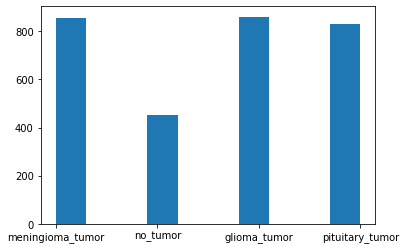

In [363]:
plt.hist(df['label'])
plt.show()

### The are two general ways in which imbalanced datasets can be handled. One option is to perform under-sampling of the dominant classes, this process ensures all remaining datapoints are real and a good representation of the class (subject to an unbiased sample removal) but implies reducing the size of the training data. Another option is to over-sample the minority class by either repeating existing datapoints or statiatically synthesising new points, this method increases the size of the training data but is not as accurate as under-sampling because the new datapoints are not real samples. It is also common to perform both methods sequentially to generate new points and then clear up the feature space.

### Given that the size of the training data is low (relative to deep learning techniques requirements) over-sampling was chosen as dataset balancing method. Particularly, the Support Vector Machine (SVM) variant of the Synthetic Minority Over-sampling Technique (SMOTE) algorithm was chosen as over-sampling method since it is designed to amplify the number of datapoints by connecting inliers and outliers in the minority class while giving a greater preference to outliers. SVMSMOTE ensures new datapoints are balanced but also harder to classify, hence implying that good results from classifiers will be due to correct feature selection rather than meaningless clearly separated samples. 

In [4]:
# Create a feature matrix X(NxM) where N = number of data samples and M = number of features 
# Create a labels vector y(Nx1)

X = df.iloc[:,5:].to_numpy() # remove the first 5 columns since they are not features
y = df['tumour']

# Use SVMSMOTE to over-sample the dataset
X_resampled,y_resampled = SVMSMOTE().fit_resample(X,y)

print(np.shape(X_resampled))
print(np.shape(y_resampled))

(5092, 44)
(5092,)


## Feature extraction

### Simple initial features such as average pixel intensity, entropy, etc.

In [187]:
# Loop over all images and calculate simple initial features such as average pixel intensity, entropy, etc.
avg = []
ent = []
var = []
ratioh = []
ratiov = []
ratiod = []
rms = []
median = []
for idx,filename in enumerate(df.loc[:,'file_name']):
    im = Image.open('dataset/image/'+filename).convert('L')
    ent.append(im.entropy())
    avg.append(ImageStat.Stat(im).mean[0])
    median.append(ImageStat.Stat(im).median[0])
    var.append(ImageStat.Stat(im).var[0])
    rms.append(ImageStat.Stat(im).rms[0])
    rms.append(ImageStat.Stat(im).rms[0])

    im = np.array(im) # convert to numpy array
    left=0
    right=0
    top=0
    bottom=0
    topd=0
    bottomd=0
    for j in range(0,512):
        for k in range(0,512):
            if k>=256:
                top = top+im[j,k]
            else:
                bottom = bottom+im[j,k]
            
            if j>=256:
                right = right+im[j,k]
            else:
                left = left+im[j,k]
            if j>k:
                topd = topd+im[j,k]
            else:
                bottomd = bottomd+im[j,k]

    ratiov.append(left/right)
    ratioh.append(top/bottom)
    ratiod.append(topd/bottomd)

df['entropy'] = ent
df['variance'] = var
df['avg_pixel_intensity'] = avg
df['median'] = median
df['rms'] = rms
df['Horizontal symmetry'] = ratioh
df['Vertical symmetry'] = ratiov
df['Diagonal symmetry'] = ratiod

### Correlation between images and archetypical or average images (mostly for different perspectives) 

In [5]:
# Testing how correlation between example images from each perspective help classifying them - top correlation seems useful 
corr_front = []
corr_side = []
corr_top = []
side = Image.open('dataset/image/IMAGE_0000.jpg').convert('L')
front = Image.open('dataset/image/IMAGE_0011.jpg').convert('L')
top = Image.open('dataset/image/IMAGE_0001.jpg').convert('L')
for idx,filename in enumerate(df.loc[:150,'file_name']):
    im = Image.open('dataset/image/'+filename).convert('L')
    corr_front.append(np.mean(signal.correlate2d(np.array(front),np.array(im))))
    corr_side.append(np.mean(signal.correlate2d(np.array(side),np.array(im))))
    corr_top.append(np.mean(signal.correlate2d(np.array(top),np.array(im))))

df.loc[:150,'corr_front'] = corr_front
df.loc[:150,'corr_side'] = corr_side
df.loc[:150,'corr_top'] = corr_top

ax = df[df['perspective']=='top'].plot('corr_top','Horizontal symmetry',kind='scatter',color='green',label='Top')
df[df['perspective']=='side'].plot('corr_top','Horizontal symmetry',kind='scatter',color='red',ax=ax,label='Side')
df[df['perspective']=='front'].plot('corr_top','Horizontal symmetry',kind='scatter',color='blue',ax=ax,label='Front')


### Wavelet transforms and GLCM features

In [96]:
feature1 = []
feature2 = []
feature3 = []
feature4 = []
feature5 = []
feature6 = []
for idx,filename in enumerate(df.loc[:,'file_name']):
    im = Image.open('dataset/image/'+filename).convert('L')
    im = np.array(im)
    LL1, (LH,HL,HH) = pywt.dwt2(im,'bior1.3')
    _, (LH2,HL2,HH2) = pywt.dwt2(LL1,'bior1.3')
    HH2 = ((HH2 - HH2.min()) * (1/(HH2.max() - HH2.min()) * 255)).astype('uint8')
    glcm = greycomatrix(HH2,distances=[5],angles=[0])
    feature1.append(greycoprops(glcm,prop='correlation')[0][0])
    feature2.append(greycoprops(glcm,prop='contrast')[0][0])
    feature3.append(greycoprops(glcm,prop='homogeneity')[0][0])
    feature4.append(greycoprops(glcm,prop='dissimilarity')[0][0])
    feature5.append(greycoprops(glcm,prop='ASM')[0][0])
    feature6.append(greycoprops(glcm,prop='energy')[0][0])

df['corr_HH2'] = feature1
df['contrast_HH2'] = feature2
df['homogeneity_HH2'] = feature3
df['dissimilarity_HH2'] = feature4
df['ASM_HH2'] = feature5
df['energy_HH2'] = feature6

### Perform dimensionality reduction

[0.55959472 0.08896831 0.0563594  0.04386882 0.03772802 0.0343005
 0.02863455 0.02826084 0.02144204 0.01839232]


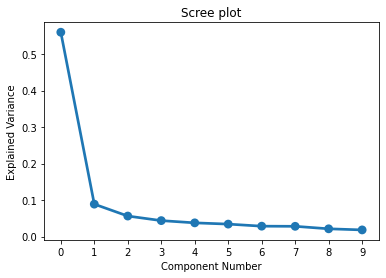

                        Dim 1     Dim 2
entropy             -0.942927 -0.080336
variance            -0.154119  0.736310
median              -0.814510  0.170089
Horizontal symmetry -0.183397 -0.131805
Vertical symmetry   -0.115669 -0.187680
Diagonal symmetry    0.223789  0.199315
pixel_sum_squared   -0.681200  0.455528
std                 -0.176615  0.751348
corr_LH             -0.126549  0.326895
contrast_LH         -0.633785  0.299774
homogeneity_LH       0.972737  0.144705
dissimilarity_LH    -0.840991  0.189880
ASM_LH               0.951863  0.201332
energy_LH            0.965853  0.211092
corr_HL              0.053228  0.126700
contrast_HL         -0.451570  0.568904
homogeneity_HL       0.971134  0.068944
dissimilarity_HL    -0.680210  0.452784
ASM_HL               0.952674  0.191337
energy_HL            0.968918  0.184439
corr_HH              0.182397 -0.076602
contrast_HH         -0.592211  0.275218
homogeneity_HH       0.953248  0.136641
dissimilarity_HH    -0.807083  0.169338


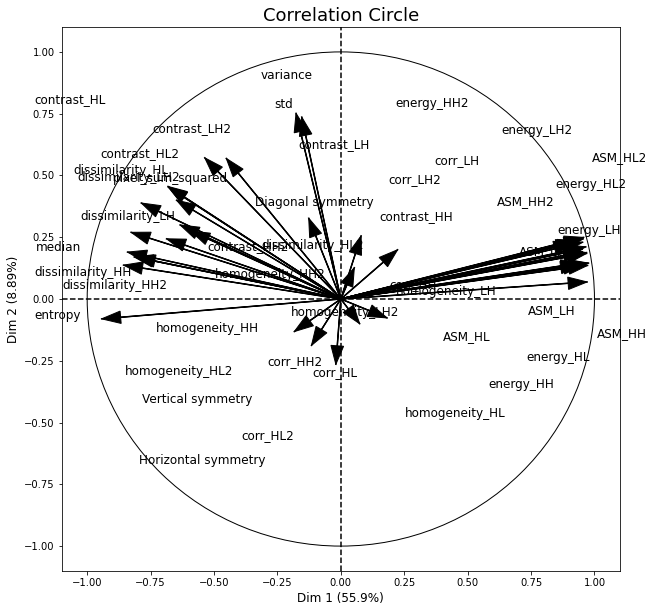

In [5]:
# Perform PCA to reduce all initial features into principal components

n_components = 10

pca = PCA(n_components=n_components)
pca.fit(X/X.std(axis=0))
print(pca.explained_variance_ratio_)

# Generate scree plot
ind = np.arange(0, n_components)
(fig, ax) = plt.subplots()
sns.pointplot(x=ind, y=pca.explained_variance_ratio_)
ax.set_title('Scree plot')
ax.set_xticks(ind)
ax.set_xticklabels(ind)
ax.set_xlabel('Component Number')
ax.set_ylabel('Explained Variance')
plt.show()

# Plot correlation circle to study the influence of each feature in clustering
fig,corr_matrix = plot_pca_correlation_graph(X/X.std(axis=0),df.iloc[:,5:].columns) # feature normalisation ensures relative values
print(corr_matrix)
fig.set_figheight(10)
fig.set_figwidth(10)

### Display images in feature space

<AxesSubplot:xlabel='Horizontal symmetry', ylabel='dissimilarity_LH'>

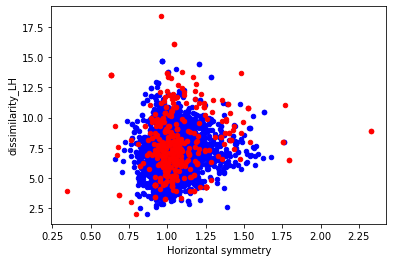

In [178]:
# Display different groups of pictures in different feature spaces to see their separability
healthy = df[df['tumour']==True]
sick = df[df['tumour']==False]
# front = df[df['perspective']=='front']

f1 = 'Horizontal symmetry'
f2 = 'dissimilarity_LH'
ax = healthy.plot(f1,f2,kind='scatter',color='blue')
sick.plot(f1,f2,kind='scatter',color='red',ax=ax)
# front.plot(f1,f2,kind='scatter',color='green',ax=ax)


## Classification

### Non-deep learning methods

### In order to validate the performance of the different algorithms hereby presented it is essential to separate the given data into training, validation and test sets. Training data is used to define the parameters of the different classifiers, the validation set is used as a means to perform an initial test of the models on unseen data as well as to tune hyper-parameters and the test data is applied at the end of the parameter and hyper-parameter optimisation process to evaluate the generalisation error performance of the trained models. The chosen technique to perform validation is K-folding. This technique is chosen because it is commonly used in the literature and it performs non-exhaustive cross-validation, hence reducing computational cost. Particularly, it is decided to split training and validation sets with the standard 5:1 ratio present in the literature (i.e. 80% to 20%).

In [40]:
# k-fold splitting
kfold = StratifiedKFold(n_splits=5,shuffle=True)

# Use non-deep learning methods such as SVM, LDA, NB, logistic regression
# Classifier training
clf = neighbors.KNeighborsClassifier()
# clf = discriminant_analysis.LinearDiscriminantAnalysis()
# clf = naive_bayes.GaussianNB()
# clf = LogisticRegression()
# clf = svm.SVC()
# clf = DecisionTreeClassifier()

# Calculate several performance metrics: accuracy, precision, recall and training/fitting time
results = cross_validate(clf,X/X.std(axis=0),y,cv=kfold,scoring=['accuracy','precision','recall'])
print(results)


{'fit_time': array([0.00347686, 0.00196648, 0.00099993, 0.00102282, 0.00099921]), 'score_time': array([0.0568378 , 0.06340551, 0.05282497, 0.05654097, 0.05284977]), 'test_accuracy': array([0.91166667, 0.89333333, 0.89666667, 0.90666667, 0.92      ]), 'test_precision': array([0.91926606, 0.91280148, 0.91465677, 0.91559633, 0.92449355]), 'test_recall': array([0.98235294, 0.96660118, 0.96856582, 0.98035363, 0.98624754])}


### Deep learning methods

In [41]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder

# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)

# Baseline model
def create_baseline():
	# create model
	model = Sequential()
	model.add(Dense(np.shape(X)[1], input_dim=np.shape(X)[1], activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# Evaluate model with standardised dataset
clf = KerasClassifier(build_fn=create_baseline,epochs=100,batch_size=5,verbose=1)
kfold = StratifiedKFold(n_splits=5,shuffle=True)
results = cross_validate(clf,X/X.std(axis=0),encoded_Y,cv=kfold,scoring=['accuracy','precision','recall'])
print(results)

Epoch 1/100
480/480 [==============================] - 1s 932us/step - loss: 0.4049 - accuracy: 0.8533
Epoch 2/100
480/480 [==============================] - 0s 750us/step - loss: 0.3449 - accuracy: 0.8596
Epoch 3/100
480/480 [==============================] - 0s 947us/step - loss: 0.3296 - accuracy: 0.8633
Epoch 4/100
480/480 [==============================] - 0s 861us/step - loss: 0.3219 - accuracy: 0.8692
Epoch 5/100
480/480 [==============================] - 0s 938us/step - loss: 0.3123 - accuracy: 0.8717
Epoch 6/100
480/480 [==============================] - 0s 958us/step - loss: 0.3030 - accuracy: 0.8742
Epoch 7/100
480/480 [==============================] - 1s 1ms/step - loss: 0.3040 - accuracy: 0.8708
Epoch 8/100
480/480 [==============================] - 1s 1ms/step - loss: 0.2970 - accuracy: 0.8754
Epoch 9/100
480/480 [==============================] - 1s 1ms/step - loss: 0.2981 - accuracy: 0.8792
Epoch 10/100
480/480 [==============================] - 1s 1ms/step - loss: 0.2

# Task B

### Simple NN

In [42]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(df['label'])
encoded_Y = encoder.transform(df['label'])
# Convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

# Baseline model
def create_baseline():
	# create model
	model = Sequential()
	model.add(Dense(np.shape(X)[1], input_dim=np.shape(X)[1], activation='relu'))
	model.add(Dense(4, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# Evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline,epochs=100,batch_size=5,verbose=1)
kfold = StratifiedKFold(n_splits=5,shuffle=True)
results = cross_validate(estimator,X/X.std(axis=0),encoded_Y,cv=kfold,scoring=['accuracy','precision','recall'])
print(results)

Epoch 1/100
480/480 [==============================] - 1s 1ms/step - loss: 1.1980 - accuracy: 0.4900
Epoch 2/100
480/480 [==============================] - 0s 776us/step - loss: 1.0062 - accuracy: 0.5775
Epoch 3/100
480/480 [==============================] - 0s 782us/step - loss: 0.9598 - accuracy: 0.6054
Epoch 4/100
480/480 [==============================] - 0s 831us/step - loss: 0.9383 - accuracy: 0.6083
Epoch 5/100
480/480 [==============================] - 0s 827us/step - loss: 0.9086 - accuracy: 0.6308
Epoch 6/100
480/480 [==============================] - 0s 821us/step - loss: 0.8751 - accuracy: 0.6392
Epoch 7/100
480/480 [==============================] - 0s 826us/step - loss: 0.8652 - accuracy: 0.6417
Epoch 8/100
480/480 [==============================] - 0s 875us/step - loss: 0.8448 - accuracy: 0.6583
Epoch 9/100
480/480 [==============================] - 1s 1ms/step - loss: 0.8337 - accuracy: 0.6617
Epoch 10/100
480/480 [==============================] - 1s 1ms/step - loss: 0

C:\Users\Rubén\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Rubén\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Rubén\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Rubén\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_score

480/480 [==============================] - 1s 992us/step - loss: 1.2036 - accuracy: 0.4863
Epoch 2/100
480/480 [==============================] - 0s 1ms/step - loss: 1.0310 - accuracy: 0.5717
Epoch 3/100
480/480 [==============================] - 1s 1ms/step - loss: 0.9808 - accuracy: 0.5942
Epoch 4/100
480/480 [==============================] - 1s 1ms/step - loss: 0.9400 - accuracy: 0.6112
Epoch 5/100
480/480 [==============================] - 1s 1ms/step - loss: 0.9217 - accuracy: 0.6229
Epoch 6/100
480/480 [==============================] - 0s 928us/step - loss: 0.8984 - accuracy: 0.6308
Epoch 7/100
480/480 [==============================] - 0s 841us/step - loss: 0.8766 - accuracy: 0.6350
Epoch 8/100
480/480 [==============================] - 0s 984us/step - loss: 0.8589 - accuracy: 0.6363
Epoch 9/100
480/480 [==============================] - 0s 958us/step - loss: 0.8393 - accuracy: 0.6454
Epoch 10/100
480/480 [==============================] - 0s 978us/step - loss: 0.8267 - accura

C:\Users\Rubén\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Rubén\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Rubén\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Rubén\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_score

Epoch 1/100
480/480 [==============================] - 1s 924us/step - loss: 1.1947 - accuracy: 0.4783
Epoch 2/100
480/480 [==============================] - 0s 824us/step - loss: 1.0172 - accuracy: 0.5754
Epoch 3/100
480/480 [==============================] - 0s 847us/step - loss: 0.9798 - accuracy: 0.5925
Epoch 4/100
480/480 [==============================] - 0s 886us/step - loss: 0.9379 - accuracy: 0.6096
Epoch 5/100
480/480 [==============================] - 0s 972us/step - loss: 0.9163 - accuracy: 0.6242
Epoch 6/100
480/480 [==============================] - 1s 1ms/step - loss: 0.8932 - accuracy: 0.6263
Epoch 7/100
480/480 [==============================] - 1s 1ms/step - loss: 0.8746 - accuracy: 0.6388
Epoch 8/100
480/480 [==============================] - 1s 1ms/step - loss: 0.8519 - accuracy: 0.6413
Epoch 9/100
480/480 [==============================] - 1s 1ms/step - loss: 0.8387 - accuracy: 0.6617
Epoch 10/100
480/480 [==============================] - 1s 2ms/step - loss: 0.820

C:\Users\Rubén\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Rubén\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Rubén\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Rubén\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_score

480/480 [==============================] - 1s 1ms/step - loss: 1.2453 - accuracy: 0.4883
Epoch 2/100
480/480 [==============================] - 1s 1ms/step - loss: 1.0414 - accuracy: 0.5646
Epoch 3/100
480/480 [==============================] - 1s 1ms/step - loss: 0.9851 - accuracy: 0.5800
Epoch 4/100
480/480 [==============================] - 1s 1ms/step - loss: 0.9602 - accuracy: 0.5950
Epoch 5/100
480/480 [==============================] - 0s 902us/step - loss: 0.9256 - accuracy: 0.6171
Epoch 6/100
480/480 [==============================] - 0s 827us/step - loss: 0.9089 - accuracy: 0.6304
Epoch 7/100
480/480 [==============================] - 0s 822us/step - loss: 0.8944 - accuracy: 0.6346
Epoch 8/100
480/480 [==============================] - 0s 856us/step - loss: 0.8791 - accuracy: 0.6375
Epoch 9/100
480/480 [==============================] - 0s 803us/step - loss: 0.8620 - accuracy: 0.6467
Epoch 10/100
480/480 [==============================] - 0s 833us/step - loss: 0.8551 - accura

C:\Users\Rubén\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Rubén\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Rubén\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Rubén\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_score

Epoch 1/100
480/480 [==============================] - 1s 1ms/step - loss: 1.2239 - accuracy: 0.4654
Epoch 2/100
480/480 [==============================] - 0s 805us/step - loss: 1.0295 - accuracy: 0.5646
Epoch 3/100
480/480 [==============================] - 0s 885us/step - loss: 0.9900 - accuracy: 0.5842
Epoch 4/100
480/480 [==============================] - 0s 909us/step - loss: 0.9472 - accuracy: 0.6042
Epoch 5/100
480/480 [==============================] - 1s 1ms/step - loss: 0.9133 - accuracy: 0.6208
Epoch 6/100
480/480 [==============================] - 0s 916us/step - loss: 0.8902 - accuracy: 0.6379
Epoch 7/100
480/480 [==============================] - 1s 1ms/step - loss: 0.8690 - accuracy: 0.6504
Epoch 8/100
480/480 [==============================] - 1s 1ms/step - loss: 0.8590 - accuracy: 0.6488
Epoch 9/100
480/480 [==============================] - 1s 1ms/step - loss: 0.8496 - accuracy: 0.6483
Epoch 10/100
480/480 [==============================] - 1s 1ms/step - loss: 0.8379 

C:\Users\Rubén\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Rubén\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\Rubén\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\Rubén\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_score